In [1]:
from Functions import plot_learning_curve
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Learning curve
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE

# algorithms
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Feature engineer 
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder, OneHotEncoder as OneHotEncoderFE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from feature_engine.imputation import (MeanMedianImputer, CategoricalImputer)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_cross_score(pipe,cv=5):
    score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring='accuracy')
    print(f'accuracy of {np.round(score.mean(),4)} and standard deviation of {np.round(score.std(),4)}')

def make_sub(pipe,subname,save_to_drive=True):
    pipe.fit(x,y)
    pred = pipe.predict(df_pred)
    
    global last_sub
    last_sub = pd.DataFrame({'PassengerId': df_pred.index,
                             'Survived': pred})
    if save_to_drive:
        last_sub.to_csv('Predições/Experiments_nb/' +subname+'.csv',header=True, index=False)
    
def err_analysis(best_score='best_sub.csv'):
    best_sub = pd.read_csv(best_score, index_col='PassengerId')
    error_analysis = best_sub.join(last_sub.set_index('PassengerId'),lsuffix='_LastSub',rsuffix='_BestSub')
    error_index = error_analysis[error_analysis['Survived_LastSub'] != error_analysis['Survived_BestSub']].index
    df = df_pred.loc[error_index].join(best_sub).join(last_sub.set_index('PassengerId'),lsuffix='_best',rsuffix='_last')
    print('Survived_best: ', df['Survived_best'].sum())
    print('\nSurvived_last: ', df['Survived_last'].sum())
    return df

In [4]:
from sklearn import set_config

set_config(display='diagram')

# Load Data

In [5]:
def load_data():
    global df
    df = pd.read_csv("Dados/train.csv",index_col=0)
    global df_pred
    df_pred = pd.read_csv("Dados/test.csv",index_col=0)
    global x
    x = df.drop('Survived',axis=1)
    global y
    y = df.Survived
    global seed
    seed = 42
    
    global x_train, x_test, y_train, y_test
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 42)
    
    global num_var, cat_var, target
    num_var = ['Age','SibSp','Parch','Fare','Cabin_Size']
    cat_var = ['Pclass','Sex','Cabin_code','Embarked','Name_title', 'Name_family']
    target = ['Survived']

In [6]:
load_data()

In [7]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature Engineer

In [70]:
class get_feature_name(BaseEstimator, TransformerMixin):
    """create column with family name  and title of each passenger"""
    def __init__(self, title:bool=True,family:bool=True):
        self.title = title
        self.family = family
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame, y:pd.Series=None):
        df = x.copy()
        try:
            if self.title:
                df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
            
            if self.family:
                df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
            
        except:
            print('erro em get_name')
        return df
    
    
class dtype_fix(BaseEstimator,TransformerMixin):
    """ corrects dtype of all initial features"""
    
    def __init__(self, Pclass_type=True):
        self.Pclass_type=Pclass_type
        pass
    
    def fit(self, x:pd.DataFrame, y:pd.Series=None):
        return self
    
    def transform(self, x:pd.DataFrame,y:pd.Series=None):
        df=x.copy()
        try:
            if self.Pclass_type:
                df['Pclass']=df['Pclass'].astype('O')            
            df['Fare']=df['Fare'].astype('float')
            df['Sex']=df['Sex'].astype('object')
            df['Age']=df['Age'].astype('float')
            df['Cabin']=df['Cabin'].astype('object')
            df['Embarked']=df['Embarked'].astype('object')
        except:
            print('erro em dtype_fix')
        return df

class Mapper(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,features:list=['Sex'],map_dicts=[{'male':1,'female':0}]):
        
        if not isinstance(map_dicts,list):
            raise ValueError('map_dicts should be a list of dictionarys')
            
        self.features = features
        self.map_dicts = map_dicts
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        
        for i,feature in enumerate(self.features):
            x[feature] = x[feature].map(self.map_dicts[i])
        return x

class Cabin_code(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,code=True,size=True):
        self.code=code
        self.size=size
        pass
        
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame,y:pd.Series=None):
        x = x.copy()
        try:
            if self.code:
                x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
            if self.size:
                x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
        except Exception as err:
            print('erro no Cabin_code')
            print(err)
        return x

In [71]:
def dtype_func(x:pd.DataFrame,y:pd.Series=None):
    df=x.copy()
    df['Pclass']=df['Pclass'].astype('O')
    return df
        
def feat_name(x:pd.DataFrame, y:pd.Series=None):
    """ extracs family name and title from the feature Name """
    df = x.copy()
    df['Name_title'] = df['Name'].apply(lambda x: x.split(",")[1]).apply(lambda x: x.split(".")[0])
    df['Name_family'] = df['Name'].apply(lambda x: x.split(",")[0])
    return df

def mapper_func(x:pd.DataFrame, y=None):
    x = x.copy()
    x['Sex'] = x['Sex'].map({'male':1,
                             'female':0})
#    x['Sex'] = x['Sex'].astype('object')
    return x

def cabin_func(x:pd.DataFrame,y:pd.Series=None):
    x = x.copy()
    x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
    x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
    return x

dtype_fix = FunctionTransformer(dtype_func)
get_feature_name = FunctionTransformer(feat_name)
Mapper = FunctionTransformer(mapper_func)
Cabin_code = FunctionTransformer(cabin_func)


In [45]:
# pipeline for categorical features processing
onehot_ct = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                     ['Pclass','Embarked','Name_title', 'Name_family','Cabin_code']),
                                    remainder='passthrough'
                                   )

# discretize Continuos features
kbins = make_column_transformer((KBinsDiscretizer(n_bins=10,encode='ordinal'),
                                     ['Fare','Age']),
                                    remainder='passthrough'
                                   )

# pipeline for numeric features processing
num_pp = Pipeline([
    ('Scaler',StandardScaler()),
    ])

#merge categorical and numeric preprocessing
merge_pp = make_column_transformer((cat_pp,make_column_selector(dtype_include='object')),
                                   (num_pp,['Fare']),
                                    remainder='passthrough')

In [47]:
# pipeline for imputing missing values
impute_pipe = Pipeline([
   ('Fix dtypes',dtype_fix()),
   ('Cabin imputer',CategoricalImputer(variables=['Cabin'], fill_value='C')),
   ('Embarked imputer',CategoricalImputer(variables=['Embarked'], imputation_method='frequent')),
   ('Numeric imputer', MeanMedianImputer(variables=['Age','Fare'],imputation_method='median'))
                    ])

# pipeline for extracting features
ext_pp = make_pipeline(get_feature_name(),
                        Cabin_code())

cat_pp = OneHotEncoderFE(variables=['Pclass', 'Embarked', 'Name_title', 'Name_family', 'Cabin_code'],drop_last=False)

seed=42
#### MODELS
lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
gbc = GradientBoostingClassifier(random_state=seed)
lgbm = LGBMClassifier(random_state=seed)
vt = VotingClassifier(voting='hard',estimators=[('lr', lr), ('rf', rf), ('gbc', gbc)])

# final pipeline
pp_pipe = Pipeline([
    ('Impute missing values',impute_pipe),
    ('Extract features',ext_pp), 
    ('Drop bad features',DropFeatures(features_to_drop=['Name','Cabin','Ticket'])),
    ('Drop numeric features',DropFeatures(features_to_drop=['Cabin_Size', 'Age','Parch', 'SibSp','Sex','Fare'])),
    ('Categorical Preprocess', cat_pp),
    ('Voting Classifier Estimator', vt)
])

final_pipe = make_pipeline(pp_pipe,
                           vt)
# cross validation
#get_cross_score(final_pipe,cv=5)

#x_1 = pp_pipe.fit_transform(x)

#make_sub(final_pipe, 'best_score', save_to_drive=False)
#err_analysis()

In [48]:
pp_pipe

Pipeline(steps=[('Impute missing values',
                 Pipeline(steps=[('Fix dtypes', dtype_fix()),
                                 ('Cabin imputer',
                                  CategoricalImputer(fill_value='C',
                                                     variables=['Cabin'])),
                                 ('Embarked imputer',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=['Embarked'])),
                                 ('Numeric imputer',
                                  MeanMedianImputer(variables=['Age',
                                                               'Fare']))])),
                ('Extract features',
                 Pipeline(steps=[('ge...
                ('Categorical Preprocess',
                 Pipeline(steps=[('OneHot categorical',
                                  OneHotEncoder(variables=['Pclass', 'Embarked',
                                                           'Name_title',
                                                           'Name_family',
                                                           'Cabin_code']))])),
                ('Voting Classifier Estimator',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(random_state=42)),
                                              ('rf',
                                               RandomForestClassifier(random_state=42)),
                                              ('gbc',
                                               GradientBoostingClassifier(random_state=42))]))])

# Confusion Matrix

In [302]:
def conf_mat():
    preddd = final_pipe.fit(x_train,y_train).predict(x_test)
    cf = confusion_matrix(y_test,preddd)
    ConfusionMatrixDisplay(cf).plot()

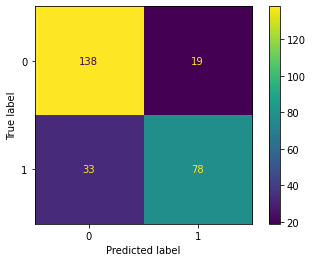

In [344]:
conf_mat()

# Recursive Feature Selection (RFE)

In [357]:
best_feat = RFE(estimator=lr, n_features_to_select=20, step=3).fit(x_1,y)

In [358]:
pd.DataFrame(best_feat.support_,index=x_1.columns).to_csv('RFE/lr_best_feats.csv')
pd.DataFrame(best_feat.ranking_,index=x_1.columns).to_csv('RFE/lr_ranking.csv')
RFE_ranking = pd.read_csv('RFE/lr_ranking.csv', index_col=0)

In [360]:
RFE_ranking[RFE_ranking['0']==1]

,0
Sex,1
Pclass_3,1
Name_title_ Mr,1
Name_title_ Master,1
Name_title_ Rev,1
Name_family_Palsson,1
Name_family_Rice,1
Name_family_Panula,1
Name_family_Goodwin,1
Name_family_Skoog,1


# Feature Importance

In [149]:
df_pred1 =  pp_pipe.transform(df_pred)
rf.fit(x_1,y)
pred = rf.predict(df_pred1)
feat_imp = pd.DataFrame(rf.feature_importances_, index=x_1.columns)

<AxesSubplot:>

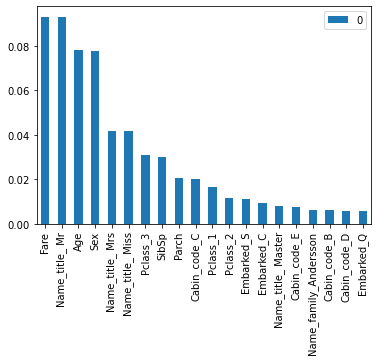

In [150]:
feat_imp.sort_values(by=0,ascending=False).head(20).plot.bar()

# Learning Curve

train_scores_mean:  0.9073033707865168 
test_scores_mean 0.8249325214989642


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

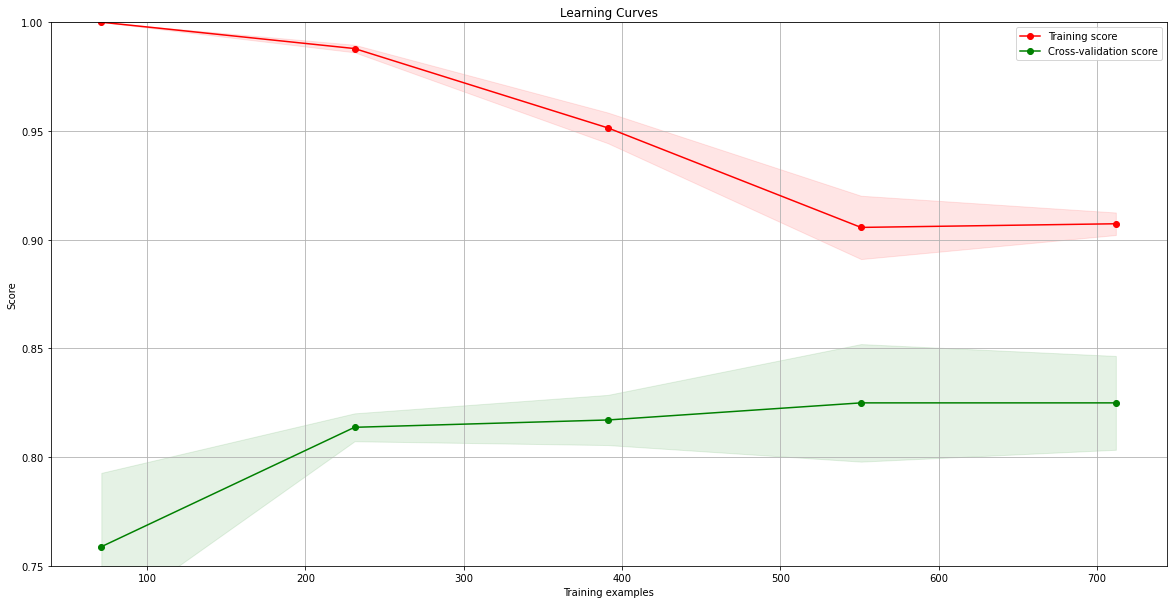

In [16]:
title = "Learning Curves"
plot_learning_curve(vt, title, x_1, y, ylim=(0.75, 1),
                    cv=5, n_jobs=-1)

train_scores_mean:  0.8946629213483147 
test_scores_mean 0.8372669637813068


<module 'matplotlib.pyplot' from 'C:\\Users\\ticom\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

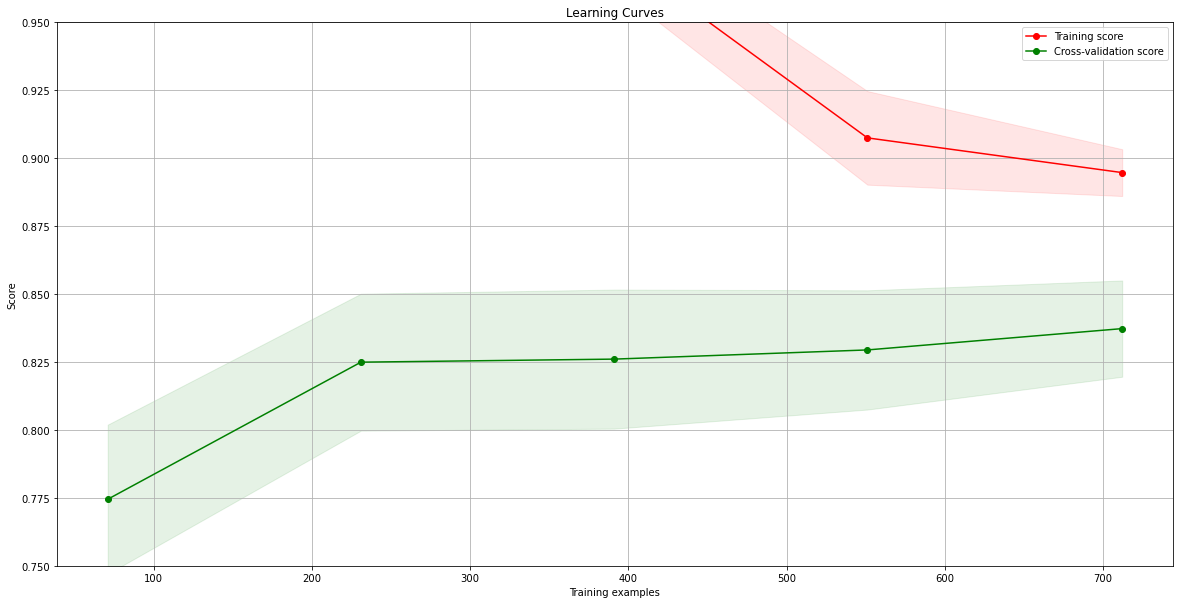

In [147]:
plot_learning_curve(vt, title, x_1, y, ylim=(0.75, 1),
                    cv=5, n_jobs=-1)

Best Result so far: Acc = 0.80382 on the leaderboard

# Error analysis

In [207]:
make_sub(final_pipe, 'best_score', save_to_drive=False)

In [208]:
err_analysis()

Survived_best:  0

Survived_last:  0


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_best,Survived_last
PassengerId,,,,,,,,,,,,


In [377]:
best_sub = pd.read_csv('best_sub.csv', index_col='PassengerId')

In [383]:
best_sub.join(df_pred,on='PassengerId')[df_pred['Sex']=='male']['Survived'].sum()

15

In [389]:
df[df['Sex']=='male']['Survived'].sum()

109

In [84]:
pipe_name_title = make_pipeline(
    
                        #categorical features transformations
                          get_feature_name,
                          DropFeatures(features_to_drop=['Name','Ticket','Cabin','Embarked']),
                          Mapper,
                          OneHotEncoderFE(variables=['Name_title','Name_family']),
                        # numeric features transformations
                          MeanMedianImputer(imputation_method='mean', variables=['Age','Fare']),
                        # model  
                        RandomForestClassifier(random_state=0))
get_cross_score(pipe_name_title)

accuracy of 0.8219 and standard deviation of 0.0307
